In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)

mps


### 모델 및 학습 정의

In [3]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
Seq_length = 5
#VALIDATION_RATE = 0.2

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, device):
        super().__init__()

        # Positional Encoding 초기화
        # 1. 비어있는 tensor 생성
        # (max_len,d_model)
        self.P_E = torch.zeros(max_len, d_model, device=device)
        # 학습되는 값이 아님으로 requires_grad 을 False로 설정
        self.P_E.requires_grad = False

        # 2. pos (0~max_len) 생성 (row 방향 => unsqueeze(dim=1))
        pos = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(dim=1)

        # 3. _2i (0~2i) 생성 (col 방향)
        # 2i는 step = 2 를 활용하여 i의 2배수를 만듦
        _2i = torch.arange(0, d_model, step= 2, dtype=torch.float, device=device)

        # 4. 제안된 positional encoding 생성 
        # (i가 짝수일때 : sin, 홀수일때 : cos)
        self.P_E[:, 0::2] = torch.sin(pos / 10000 ** (_2i / d_model))
        self.P_E[:, 1::2] = torch.cos(pos / 10000 ** (_2i / d_model))

    def forward(self,x):
        # x seq 길이에 맞춰 PE return 
        # (seq_len, d_model)
        _, seq_len,_ = x.size()
        PE_for_x = self.P_E[:seq_len,:]

        return PE_for_x

In [5]:
class MC_PE_1MAttn_use_VIT(nn.Module):
    def __init__(self):
        super().__init__()

        self.PE_layer = PositionalEncoding(30, 5, device)
        
        self.MA_layer1 = nn.MultiheadAttention(
            embed_dim = 30,
            num_heads = 5,
            batch_first=True,
            dropout = DROP_OUT_R
        )

        self.FC_layer1 = nn.Linear(30, 1)
        self.FC_layer2 = nn.Linear(5, 1)

    def forward(self, input_x):
        pe_x = self.PE_layer(input_x)
        input_x += pe_x
        ma_y1,_ = self.MA_layer1(input_x, input_x, input_x)        
        fc_y1 = self.FC_layer1(ma_y1)
        fc_y2 = self.FC_layer2(fc_y1.reshape(-1,5))

        return fc_y2

MC_PE_1MAttn = MC_PE_1MAttn_use_VIT().to(device)

In [6]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(MC_PE_1MAttn)) #사용

3757


In [7]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(MC_PE_1MAttn.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [8]:
train_losses = []

In [9]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        MC_PE_1MAttn.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = MC_PE_1MAttn(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

### Custom Dataset Type 정의

In [10]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### Multi channel LSTM 데이터 준비 (Seq_length = 5(i ~ i+5사이클로 i+6사이클 예측할 예정) , input_feature = 30(한 cycle당 30개 데이터 사용))

In [11]:
def prepareXY_forLSTM(X_ndArray, y_ndArray, Seq_length):
   X_ndArray = X_ndArray.reshape(-1,30)
   X_data = []
   for idx in range(0, X_ndArray.shape[0]):
      if (idx+1)-Seq_length < 0:
         tmp = np.zeros((Seq_length-(idx+1), 30))
         tmp = np.concatenate((tmp, X_ndArray[0:idx+1]), axis=0)
         X_data.append(tmp)
      else:
         X_data.append(X_ndArray[(idx+1)-Seq_length:idx+1])
      
   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("../BEST_MODEL/MC_LSTM_params.pt")
LSTM.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [12]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

def all_data_train_wrapper():
    data_file_indices = ["B0005", "B0006", "B0007"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
        y_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        if data_file_indices.index(d_idx) == 0 :
            X_scaled = X_scaler.fit_transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
            y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        else:
            X_scaled = X_scaler.transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
            y_scaled = y_scaler.transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY_forLSTM(X_scaled, y_scaled, Seq_length)
        X_data = torch.from_numpy(X_data).type(torch.float)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)
        
        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [13]:
all_data_train_wrapper()

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.434644,1.508670,29.334717,5.500
76,2,3.814079,1.510073,27.739727,234.078
152,2,3.881686,1.509227,26.890304,511.156
228,2,3.937241,1.508747,26.481944,875.062
304,2,3.979605,1.506559,26.476934,1364.266
...,...,...,...,...,...
375596,169,4.205285,0.409958,26.151950,3460.406
375852,169,4.205106,0.261199,25.147212,4206.797
376108,169,4.204985,0.184375,24.550544,4952.406
376364,169,4.206357,0.135819,24.199547,5697.531


epoch :  0 train loss:  0.838254664093256
epoch :  10 train loss:  0.2085326686501503
epoch :  20 train loss:  0.1716348398476839
epoch :  30 train loss:  0.12298759445548058
epoch :  40 train loss:  0.10283115599304438
epoch :  50 train loss:  0.06153045641258359
epoch :  60 train loss:  0.05096097197383642
epoch :  70 train loss:  0.03440817049704492
epoch :  80 train loss:  0.03380616754293442
epoch :  90 train loss:  0.03130933688953519
epoch :  100 train loss:  0.024043554672971368
epoch :  110 train loss:  0.0197452871943824
epoch :  120 train loss:  0.014986858295742422
epoch :  130 train loss:  0.02159931935602799
epoch :  140 train loss:  0.01820452802348882
epoch :  150 train loss:  0.013261976186186075
epoch :  160 train loss:  0.011300980171654373
epoch :  170 train loss:  0.008619230997283012
epoch :  180 train loss:  0.013967844191938639
epoch :  190 train loss:  0.009510721050901338
epoch :  200 train loss:  0.009236759156920016
epoch :  210 train loss:  0.00871289806673

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.320249,1.515595,31.861155,5.500
76,2,3.772765,1.513079,29.518580,234.078
152,2,3.869867,1.512962,28.012962,511.156
228,2,3.928052,1.515339,27.151827,875.062
304,2,3.968767,1.513685,26.699932,1364.266
...,...,...,...,...,...
375596,169,4.198806,0.349829,25.757573,3460.406
375852,169,4.199172,0.246677,24.935181,4206.797
376108,169,4.199734,0.176216,24.455348,4952.406
376364,169,4.199159,0.129508,24.188771,5697.531


epoch :  0 train loss:  0.03535869996994734
epoch :  10 train loss:  0.011134798172861338
epoch :  20 train loss:  0.008459734555799514
epoch :  30 train loss:  0.01116220187395811
epoch :  40 train loss:  0.01096192782279104
epoch :  50 train loss:  0.008715139352716506
epoch :  60 train loss:  0.00893639144487679
epoch :  70 train loss:  0.007508478127419949
epoch :  80 train loss:  0.009717628359794617
epoch :  90 train loss:  0.0071297293761745095
epoch :  100 train loss:  0.005914015520829707
epoch :  110 train loss:  0.008917216560803354
epoch :  120 train loss:  0.010293703933712095
epoch :  130 train loss:  0.00894646451342851
epoch :  140 train loss:  0.008112745068501681
epoch :  150 train loss:  0.00745292822830379
epoch :  160 train loss:  0.008049257972743362
epoch :  170 train loss:  0.008616457809694111
epoch :  180 train loss:  0.007010301516856998
epoch :  190 train loss:  0.008554931147955358
epoch :  200 train loss:  0.007638894545380026
epoch :  210 train loss:  0.0

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.270404,1.491025,30.573112,5.500
76,2,3.785553,1.491617,28.583428,234.078
152,2,3.881019,1.490421,27.391036,511.156
228,2,3.937696,1.491074,26.781612,875.062
304,2,3.978918,1.490915,26.575697,1364.266
...,...,...,...,...,...
375596,169,4.211561,0.512472,26.321016,3460.406
375852,169,4.212398,0.330517,25.159387,4206.797
376108,169,4.213197,0.224771,24.448661,4952.406
376364,169,4.211974,0.149447,24.056267,5697.531


epoch :  0 train loss:  0.004589964199112728
epoch :  10 train loss:  0.0024429196200799197
epoch :  20 train loss:  0.001945040829014033
epoch :  30 train loss:  0.00264117747428827
epoch :  40 train loss:  0.0028667226288234815
epoch :  50 train loss:  0.0022946737881284207
epoch :  60 train loss:  0.0016959361819317564
epoch :  70 train loss:  0.001978237422008533
epoch :  80 train loss:  0.0024629385443404317
epoch :  90 train loss:  0.0021614041179418564
epoch :  100 train loss:  0.002187149235396646
epoch :  110 train loss:  0.0020532308117253706
epoch :  120 train loss:  0.002541721740271896
epoch :  130 train loss:  0.0019312104705022648
epoch :  140 train loss:  0.0023118163517210633
epoch :  150 train loss:  0.001451722186175175
epoch :  160 train loss:  0.0019069984409725294
epoch :  170 train loss:  0.0015920536534395069
epoch :  180 train loss:  0.0016835635178722441
epoch :  190 train loss:  0.002181171585107222
epoch :  200 train loss:  0.002204277872806415
epoch :  210 

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

MC_LSTM_params = MC_LSTM.state_dict()
torch.save(MC_LSTM_params, "../BEST_MODEL/MC_LSTM_params.pt")

### B0005 예측

In [14]:
x_df = pd.read_csv(f"../Data/DataFrame/B0018_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
y_df = pd.read_csv(f"../Data/DataFrame/B0018_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
y_scaled = y_scaler.transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY_forLSTM(X_scaled, y_scaled,Seq_length)
X_data = torch.from_numpy(X_data).type(torch.float)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

MC_PE_1MAttn.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = MC_PE_1MAttn(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.479525,1.515638,24.286875,5.219
257,2,3.938450,1.516332,24.243205,653.547
514,2,3.997673,1.515629,25.168382,1303.219
771,2,4.049742,1.515579,26.206501,1952.907
1028,2,4.124331,1.517625,27.305446,2602.360
...,...,...,...,...,...
190602,134,4.198443,0.425873,25.797876,3527.000
190702,134,4.198810,0.274652,24.716367,4252.766
190802,134,4.200036,0.192107,24.088869,4977.859
190902,134,4.199606,0.136557,23.701478,5706.000


In [15]:
predicts_df

,0
0,1.825548
1,1.811742
2,1.791517
3,1.775536
4,1.782186
...,...
126,1.418573
127,1.420847
128,1.413036
129,1.404318


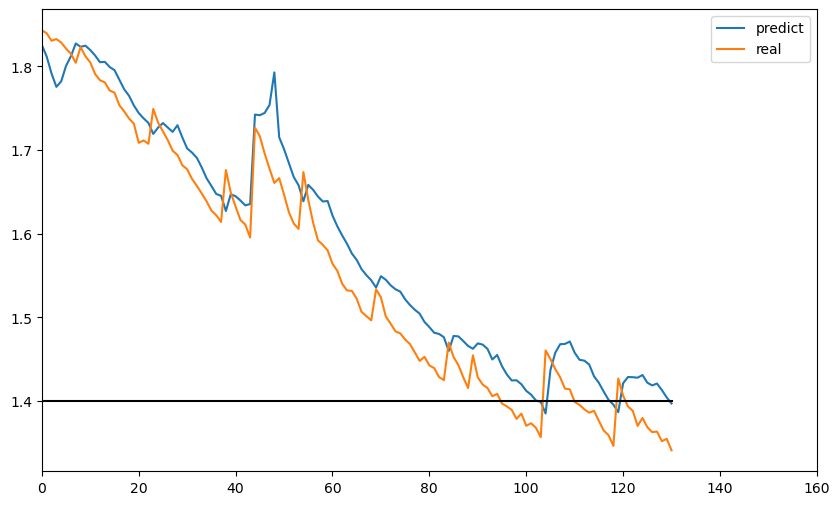

In [16]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

In [17]:
predicts_df.to_csv("./MC_PE_1MAttn.csv", index = False)

In [18]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_df.values.reshape(-1), predicts_df.loc[:,0].values.reshape(-1)) ** 0.5

RMSE

0.04271173126521216

In [19]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(y_df.values.reshape(-1), predicts_df.loc[:,0].values.reshape(-1))

MAPE

0.02563410493249414